In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras import losses

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical


In [3]:
#讀入minst資料
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()


X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)


X_train = X_train / X_train.max()
X_test = X_test / X_test.max()


y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [24]:
#construct VAE model
enc_1 = Dense(400, activation='sigmoid')
enc_2 = Dense(200, activation='sigmoid')
enc_3 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(450, activation='sigmoid')
dec_2 = Dense(225, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')


In [26]:
#encoder
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [27]:
#抽樣
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [28]:
#decoder
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [29]:
#組裝
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 400)          314000      input_7[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 200)          80200       dense_17[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            402         dense_18[0][0]                   
____________________________________________________________________________________________

In [32]:
#loss function
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)
VAE.compile(optimizer=Adam())

In [33]:
#VAE TRAINING
VAE.fit(X_train, batch_size=500, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 15s 251us/sample - loss: 123.7285
Epoch 2/5
60000/60000 [==============================] - 4s 68us/sample - loss: 105.1608
Epoch 3/5
60000/60000 [==============================] - 3s 51us/sample - loss: 100.1738
Epoch 4/5
60000/60000 [==============================] - 3s 51us/sample - loss: 98.7364
Epoch 5/5
60000/60000 [==============================] - 3s 51us/sample - loss: 95.9477


In [34]:
#切割模型(VAE ENCODER)

VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_18 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 402       
Total params: 394,602
Trainable params: 394,602
Non-trainable params: 0
_________________________________________________________________


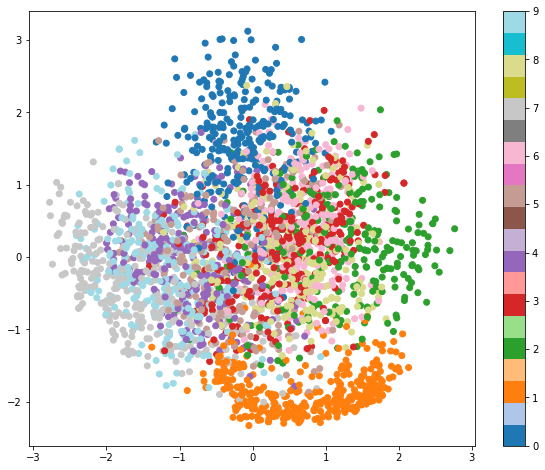

In [41]:
#視覺化ENCODER
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

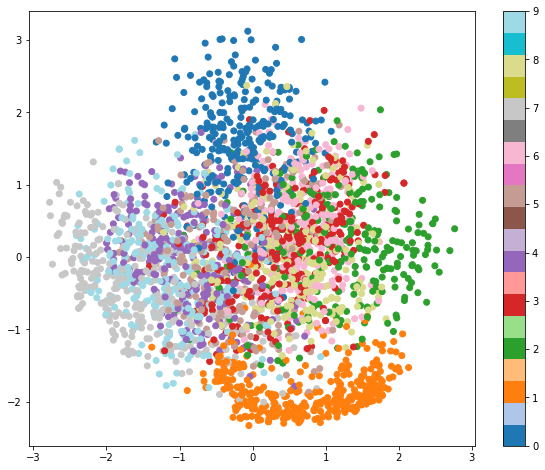

In [42]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [49]:
#visualze decoder
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 225)               675       
_________________________________________________________________
dense_24 (Dense)             (None, 784)               177184    
Total params: 177,859
Trainable params: 177,859
Non-trainable params: 0
_________________________________________________________________


In [52]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [54]:
n=20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

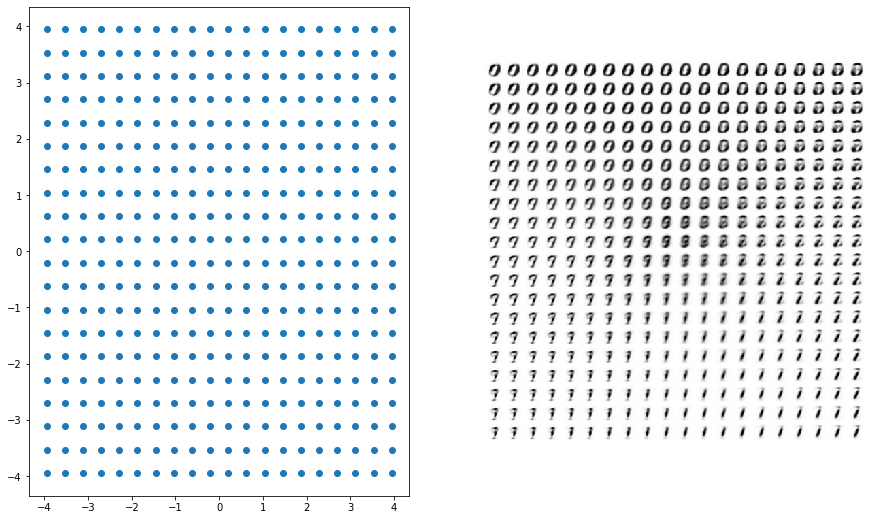

In [55]:
#視覺化-Decoder
plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [56]:
#動態
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')
from ipywidgets import interact, IntSlider, FloatSlider
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>